# Customer Data Product Analysis Sample

#### Customer Data Product has the customer demographics data that is consumed from CRM source Systems. Various statistics can be observed from the source data and both for active and in-active customers. The data is refreshed daily with 5 years of history. 



In [ ]:
import pyspark.sql as sql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io import gbq

In [4]:
session = sql.SparkSession.builder.enableHiveSupport().getOrCreate()

In [5]:
session.caseSensitive="TRUE"

In [6]:
session.sparkContext.setLogLevel("OFF")

In [7]:
session.sql('show databases;').show()

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


+--------------------+
|           namespace|
+--------------------+
|             default|
|   customer_raw_zone|
|customer_curated_...|
|customer_data_pro...|
+--------------------+



In [7]:
session.sql('show tables in customer_curated_zone;').show()

+--------------------+-----------------+-----------+
|            database|        tableName|isTemporary|
+--------------------+-----------------+-----------+
|customer_curated_...|cc_customers_data|      false|
|customer_curated_...|   customers_data|      false|
+--------------------+-----------------+-----------+



# Preview top 10 items in Customer Table

In [8]:
df_customer_data=session.sql('select ssn,first_name, last_name, city, state, latitude,longitude, job from customer_curated_zone.customers_data order by client_id limit 10;')

df_customer_data.show()

df_customer_data=df_customer_data.toPandas()

+-----------+----------+---------+--------------+-----+--------+---------+--------------------+
|        ssn|first_name|last_name|          city|state|latitude|longitude|                 job|
+-----------+----------+---------+--------------+-----+--------+---------+--------------------+
|215-31-2707|     Brian| Mcdonald|Pawleys Island|   SC|-79.1341|  33.4508|Scientist, audiol...|
|875-81-8999|      Chad|   Oneill|     Long Lake|   MI|-83.8516|  44.4416|Secondary school ...|
|679-60-5089|   Carolyn|   Cooper|     Fairbanks|   IN| -87.547|  39.1901|Teacher, secondar...|
|679-60-5089|   Carolyn|   Cooper|     Fairbanks|   IN| -87.547|  39.1901|Teacher, secondar...|
|550-14-4591|     Derek|   Cooper|        Dudley|   MO| -90.121|   36.811| Magazine journalist|
|144-63-7239|   Jeffrey|     Kane|   Christopher|   IL|-89.0574|  37.9849|Forest/woodland m...|
|355-89-6441|   Antonio|   Rogers|       Thaxton|   MS|-89.1515|  34.3136|Engineer, control...|
|791-52-0658|   Michael|    Morse|    Wa

# Distribution of Customers by State



In [42]:
df_state_totals=session.sql('Select state, count(*) as customer_count from customer_curated_zone.customers_data group by state')

pandas_state_totals = df_state_totals.toPandas()

pandas_state_totals.set_index('state', inplace=True)
#pandas_state_totals.head()

<AxesSubplot:xlabel='state'>

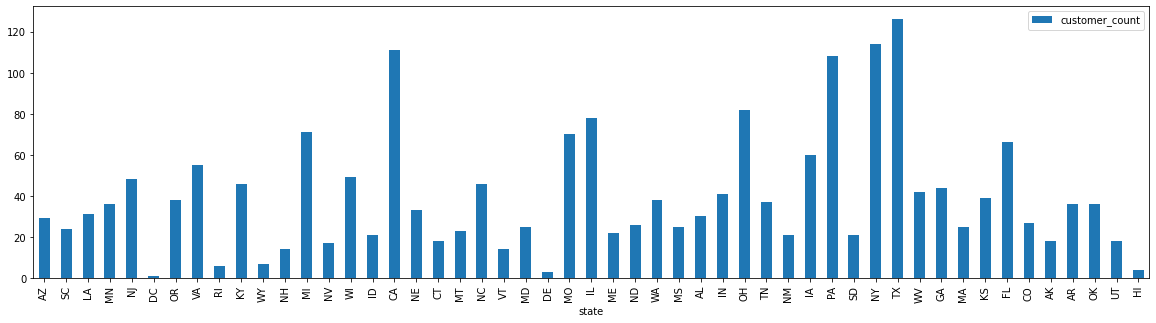

In [11]:
pandas_state_totals.plot(kind='bar',figsize=(20,5))

# Distribution of Customers by job 

<AxesSubplot:xlabel='job'>

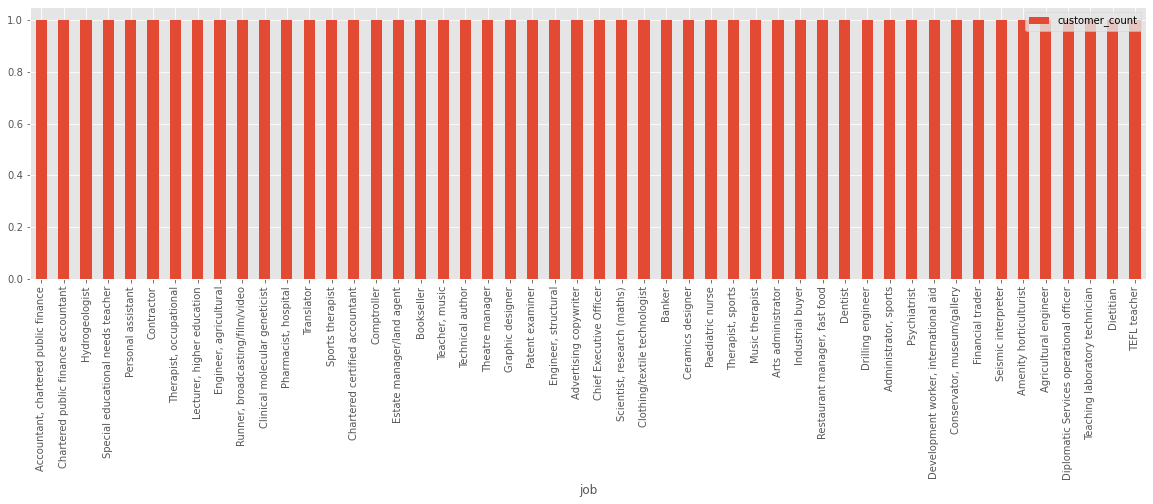

In [30]:
df_job_totals=session.sql('Select job as job, count(*) as customer_count from customer_curated_zone.customers_data group by job order by customer_count limit 50')

pandas_job_totals = df_job_totals.toPandas()

pandas_job_totals.set_index('job', inplace=True)

pandas_job_totals.plot(kind='bar',figsize=(20,5))

<AxesSubplot:ylabel='age_group'>

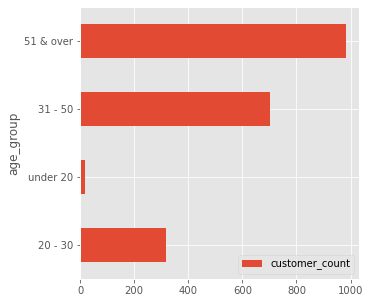

In [41]:
df_state_totals=session.sql('select case when datediff(now(), dob) / 365.25 > 50 then "51 & over" when datediff(now(), dob) / 365.25 > 30 then "31 - 50" when datediff(now(), dob) / 365.25 > 19 then "20 - 30" else "under 20" end as age_group, count(*) as customer_count from customer_curated_zone.customers_data group by age_group ')

df_state_totals = df_state_totals.toPandas()

df_state_totals.set_index('age_group', inplace=True)

df_state_totals.plot(kind='barh',figsize=(5,5))

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip( df_customer_data["longitude"], df_customer_data["latitude"])]
#gdf = gpd.GeoDataFrame(df_customer_data, geometry=geometry)

gdf = gpd.GeoDataFrame(df_customer_data,geometry=geometry)
gdf.head()

,ssn,first_name,last_name,city,state,latitude,longitude,job,geometry
0,215-31-2707,Brian,Mcdonald,Pawleys Island,SC,-79.1341,33.4508,"Scientist, audiological",POINT (33.451 -79.134)
1,875-81-8999,Chad,Oneill,Long Lake,MI,-83.8516,44.4416,Secondary school teacher,POINT (44.442 -83.852)
2,679-60-5089,Carolyn,Cooper,Fairbanks,IN,-87.5470,39.1901,"Teacher, secondary school",POINT (39.190 -87.547)
3,679-60-5089,Carolyn,Cooper,Fairbanks,IN,-87.5470,39.1901,"Teacher, secondary school",POINT (39.190 -87.547)
4,550-14-4591,Derek,Cooper,Dudley,MO,-90.1210,36.8110,Magazine journalist,POINT (36.811 -90.121)


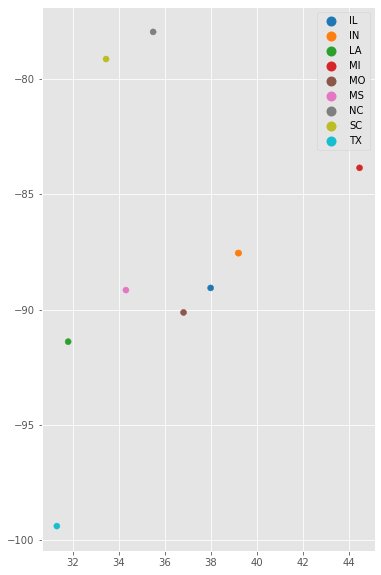

In [15]:
import matplotlib
import matplotlib.pyplot as plt


matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 10)

BBox = ((gdf.longitude.min(),   gdf.longitude.max(),      
         gdf.latitude.min(), gdf.latitude.max()))

gdf.plot(column='state', categorical=True, legend=True)
plt.show()

In [16]:
import folium

In [63]:
print(BBox)

(31.3173, 44.4416, -99.3833, -77.9578)


Text(0.5, 1.0, 'State')

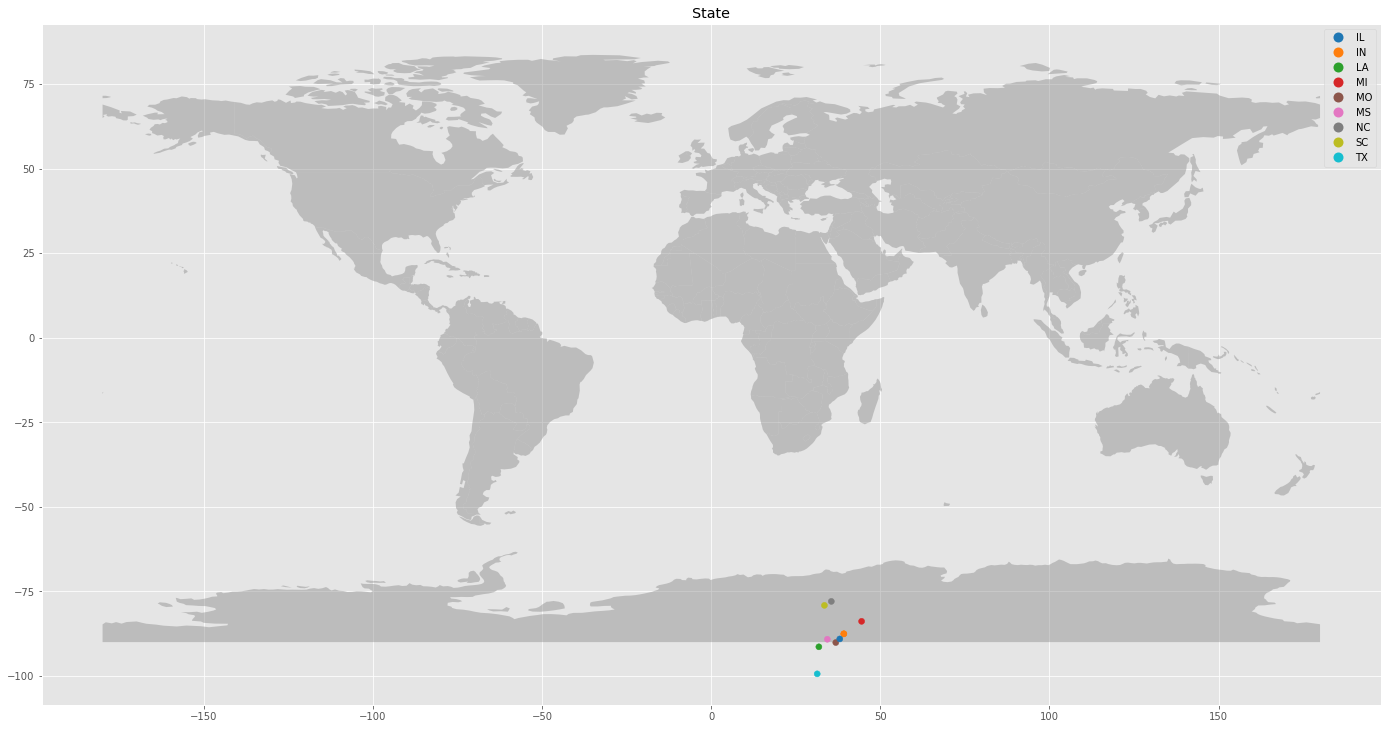

In [23]:
#import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(24,18))
world.plot(ax=ax, alpha=0.4, color='grey')
gdf.plot(column='state', ax=ax, legend=True)
plt.title('State')


In [73]:
gpd.datasets.available

['naturalearth_lowres', 'naturalearth_cities', 'nybb']

In [24]:
# Stamen Terrain
map = folium.Map(location = [31.3173,-99.3833], tiles = "Stamen Terrain", zoom_start = 9)
map

In [26]:
# OpenStreetMap
#map = folium.Map(location = [13.406,80.110], tiles='OpenStreetMap' , zoom_start = 9)
#map